In [1]:
import os
import subprocess
import xugrid as xu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import animation
from mpl_toolkits.basemap import Basemap
import contextily as cx  
import ERA_5_analysis_support as era5
import xarray as xr
#import 
%matplotlib inline

### Hurrywave

In [2]:
base_path = r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest'

model_name = 'Sinterklaas_NorthSea'
data_name = 'Sinterklaas_NorthSea'

model_path = os.path.join(base_path, '04_modelruns',model_name)

data_path = os.path.join(base_path, '01_data')

# ERA 5 data path
era_5_file = os.path.join(data_path,'ERA_5_data', data_name,f'{data_name}_era5_data.nc')

# Buoy data path
# buoy_data_path = os.path.join(data_path, 'buoy_data', 'buoy_data_2020_2024.nc')

# Buoy data path
buoy_data_path = os.path.join(data_path, 'Waterinfo_RWS', 'Sinterklaas_NorthSea_Nobnd')
print(model_path)

C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\04_modelruns\Sinterklaas_NorthSea


### Get station names

In [3]:
def read_station_names_from_obs(file_path):
    names = []
    with open(file_path, 'r') as f:
        for line in f:
            if '#' in line:
                name = line.split('# ')[1].strip()
                names.append(name)
    return names

obs_file_path = os.path.join(model_path, 'hurrywave.obs')
station_names = read_station_names_from_obs(obs_file_path)

# Extract Hurrywave results

In [4]:
### Post-process Hurrywave results
# Get the results from the netcdf file

nc_file = os.path.join(model_path,'hurrywave_map.nc')
his_file = os.path.join(model_path,'hurrywave_his.nc')

output_dir = os.path.join(model_path, '1_postprocessing')
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

xu_nc = xu.open_dataset(nc_file , decode_times=True)

modig = {"msk": xu_nc["msk"],
         "zb": xu_nc["zb"],
         "Hm0": xu_nc["hm0"],
         #"Hm0_max": xu_nc["hm0max"],
         "Tp": xu_nc["tp"],
         "DIR": xu_nc["wavdir"],
         "ds": xu_nc["dirspr"],
         #"windspeed": xu_nc["windspeed"]
        }

# Assuming "time" is available in modig dictionary
time_variable =  xu_nc["time"]

xu_nc.close()

his = xu.open_dataset(his_file)
his = his.assign_coords({"stations": station_names})
# his = his.assign_coords({"stations": [x.decode("utf-8").strip() for x in his.station_name.values]})



In [5]:
# (OPTIONAL) Print available parameters in history-file
print(f"{'Variable Name':<15} {'Long Name':<65} {'Units':<15} {'Dimensions':<40}")
for var_name, data_array in his.variables.items():
    dimensions = str(data_array.dims)
    long_name = data_array.attrs.get('long_name', 'N/A')
    units = data_array.attrs.get('units', 'N/A')
    print(f"{var_name:<15}  {long_name:<65} {units:<15} {dimensions:<40}")

Variable Name   Long Name                                                         Units           Dimensions                              
inp              N/A                                                               N/A             ()                                      
station_id       N/A                                                               N/A             ('stations',)                           
station_name     N/A                                                               N/A             ('stations',)                           
station_x        original_x_coordinate_of_station                                  m               ('stations',)                           
station_y        original_y_coordinate_of_station                                  m               ('stations',)                           
station_z        bed_level_of_station                                              m               ('stations',)                           
crs              N/A 

In [6]:
def extract_data(ds: xr.Dataset):
    """
    Extract data from xarray Dataset into nested dictionary:
    df['stationname']['variablename'].values

    Parameters:
    - ds: xarray.Dataset with a 'stations' coordinate

    Returns:
    - dict of dicts: df[station][variable] = values
    """
    nested_dict = {}
    
    for station in ds.stations.values:
        station_data = ds.sel(stations=station)
        nested_dict[station] = {}
        
        for var in ds.data_vars:
            nested_dict[station][var] = station_data[var].values

        # Include coordinates like "time" in the extraction
        for coord in ds.coords:
            nested_dict[station][coord] = station_data[coord].values
            
    return nested_dict


df_model = extract_data(his)
station_list_model = list(df_model.keys())

# Extract ERA_5 Data


In [7]:
def extract_data_era5(ds, latitudes, longitudes, station_names):
    station_data = []

    for name, lat, lon in zip(station_names, latitudes, longitudes):
        point_data = ds.sel(latitude=lat, longitude=lon, method='nearest')
        point_data = point_data.expand_dims(dim='stations')
        point_data = point_data.assign_coords(stations=[name])
        station_data.append(point_data)

    return xr.concat(station_data, dim='stations')

In [ ]:
era5_data = xu.open_dataset(era_5_file)

print("Closest latitude in grid:", era5_data.latitude.sel(latitude=52.0, method='nearest').values)
print("Closest longitude in grid:", era5_data.longitude.sel(longitude=3.25, method='nearest').values)

def extract_station_era5_data(ds, latitudes, longitudes, station_names):
    station_data = []

    for name, lat, lon in zip(station_names, latitudes, longitudes):
        point_data = ds.sel({ds.latitude.dims[0]: lat, ds.longitude.dims[0]: lon}, method='nearest')
        point_data = point_data.expand_dims(dim='stations')
        point_data = point_data.assign_coords(stations=[name])
        station_data.append(point_data)

    return xr.concat(station_data, dim='stations')

# --- Robust ERA5 extraction: always use nearest valid wave grid point ---
import numpy as np

def find_nearest_valid_wave_point(ds, lat, lon, wave_var="swh", max_radius=5):
    """
    Find the nearest grid point to (lat, lon) where wave_var is not all NaN.
    Returns (lat_val, lon_val) of the valid grid point.
    """
    lat_vals = ds.latitude.values
    lon_vals = ds.longitude.values
    lat_idx = np.abs(lat_vals - lat).argmin()
    lon_idx = np.abs(lon_vals - lon).argmin()
    # If valid, return
    if not np.isnan(ds[wave_var][:, lat_idx, lon_idx]).all():
        return lat_vals[lat_idx], lon_vals[lon_idx]
    # Otherwise, search nearby grid points (within a max_radius window)
    for radius in range(1, max_radius+1):
        for dlat in range(-radius, radius+1):
            for dlon in range(-radius, radius+1):
                if dlat == 0 and dlon == 0:
                    continue
                new_lat_idx = lat_idx + dlat
                new_lon_idx = lon_idx + dlon
                if (0 <= new_lat_idx < len(lat_vals)) and (0 <= new_lon_idx < len(lon_vals)):
                    if not np.isnan(ds[wave_var][:, new_lat_idx, new_lon_idx]).all():
                        return lat_vals[new_lat_idx], lon_vals[new_lon_idx]
    # If not found, return original (will be NaN)
    return lat_vals[lat_idx], lon_vals[lon_idx]

# --- Use this robust extraction for all stations ---
custom_obs = False # Set to True if you want to use custom observation points
if custom_obs:
    x = [3.27503678, 2.93575, 4.15028575, 1.166099, 3.218932, 4.01222222, 4.05698307]
    y = [51.99779895, 54.32566667, 52.92535269, 61.338188, 53.21701, 54.11666667, 52.54921399]
    station_names = ['Euro platform','Platform D15-A','Platform Hoorn Q1-A','North Cormorant','K13 Alpha','Platform F16-A','IJmuiden munitiestortplaats']
else: # Use the values used in obs file
    x = [float(df_model[station]['station_x']) for station in df_model]
    y = [float(df_model[station]['station_y']) for station in df_model]
    station_names = list(df_model.keys())

# Find nearest valid grid point for each station
valid_latitudes = []
valid_longitudes = []
for lat, lon, name in zip(y, x, station_names):
    vlat, vlon = find_nearest_valid_wave_point(era5_data, lat, lon, wave_var="swh")
    print(f"{name}: requested ({lat:.3f}, {lon:.3f}) -> using ({vlat:.3f}, {vlon:.3f})")
    valid_latitudes.append(vlat)
    valid_longitudes.append(vlon)

era5_data_stations = extract_data_era5(era5_data, valid_latitudes, valid_longitudes, station_names)
df_era5 = extract_data(era5_data_stations)

Closest latitude in grid: 52.0
Closest longitude in grid: 3.25
Number of stations in the dictionary: 7
Euro platform: Latitude: 52.0, Longitude: 3.25
Platform D15-A: Latitude: 54.25, Longitude: 3.0
Platform Hoorn Q1-A: Latitude: 53.0, Longitude: 4.25
North Cormorant: Latitude: 61.25, Longitude: 1.25
K13 Alpha: Latitude: 53.25, Longitude: 3.25
Platform F16-A: Latitude: 54.0, Longitude: 4.0
IJmuiden munitiestortplaats: Latitude: 52.5, Longitude: 4.0


In [9]:
era5.print_variables(era5_data)

# variable_names = list(data.variables.keys())
# print(variable_names)

Variable Name   Long Name                                                         Units           Dimensions                              
u10              10 metre U wind component                                         m s**-1         ('stations', 'valid_time')              
v10              10 metre V wind component                                         m s**-1         ('stations', 'valid_time')              
mwd              Mean wave direction                                               Degree true     ('stations', 'valid_time')              
mwp              Mean wave period                                                  s               ('stations', 'valid_time')              
pp1d             Peak wave period                                                  s               ('stations', 'valid_time')              
swh              Significant height of combined wind waves and swell               m               ('stations', 'valid_time')              
valid_time       time

In [12]:
print(df_era5['Euro platform']['mwd'])

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]


KeyError: "no index found for coordinate 'latitude'"

# Extract Waterinfo Data

In [11]:
file_dict = {
    'Euro platform': os.path.join(buoy_data_path, 'EURPFM-10946.nc'),
    'Platform D15-A': os.path.join(buoy_data_path, 'D15-10968.nc'),
    'Platform Hoorn Q1-A': os.path.join(buoy_data_path, 'Q1-10996.nc'),
    'North Cormorant': os.path.join(buoy_data_path, 'NORTHCMRT-10939.nc'),
    # 'K13 Alpha': os.path.join(buoy_data_path, 'K13-10969.nc'),
    'Platform F16-A': os.path.join(buoy_data_path, 'F16-10989.nc'),
    'IJmuiden munitiestortplaats': os.path.join(buoy_data_path, 'IJMDMNTSPS-13180.nc'),
}



In [12]:
def extract_data_buoys(file_dict):
    """
    Load multiple buoy NetCDF files into a nested dictionary:
    df[station_name][variable] = values
    
    Parameters:
    - file_dict: dict mapping station names to file paths
    
    Returns:
    - nested dict: df[station][variable]
    """
    data_dict = {}

    for station, file_path in file_dict.items():
        ds = xr.open_dataset(file_path)
        data_dict[station] = {}

        for var in ds.data_vars:
            data_dict[station][var] = ds[var].values

    return data_dict

file_path = list(file_dict.values())[5]
print(file_path)
# Load buoy data
data_buoys = xr.open_dataset(file_path)

# (OPTIONAL) Print available parameters in history-file
print(f"{'Variable Name':<15} {'Long Name':<65} {'Units':<15} {'Dimensions':<40}")
for var_name, data_array in data_buoys.variables.items():
    dimensions = str(data_array.dims)
    long_name = data_array.attrs.get('long_name', 'N/A')
    units = data_array.attrs.get('units', 'N/A')
    print(f"{var_name:<15}  {long_name:<65} {units:<15} {dimensions:<40}")

# df_buoys = extract_data_buoys(file_dict)

C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\01_data\Waterinfo_RWS\Sinterklaas_NorthSea_Nobnd\IJMDMNTSPS-13180.nc
Variable Name   Long Name                                                         Units           Dimensions                              
WaarnemingMetadata.KwaliteitswaardecodeLijst  N/A                                                               N/A             ('time',)                               
Meetwaarde.Waarde_Numeriek  N/A                                                               N/A             ('time',)                               
Meetwaarde.Waarde_Alfanumeriek  N/A                                                               N/A             ('time',)                               
time             N/A                                                               N/A             ('time',)                               


# POSTPROCESS

In [13]:
def rmse(obs, pred):
    """Root Mean Square Error"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    return np.sqrt(np.mean((pred - obs) ** 2))

def bias(obs, pred):
    """Mean Bias (Mean Error)"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    return np.mean(pred - obs)

def scatter_index(obs, pred):
    """Scatter Index: RMSE normalized by mean of observations"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    return rmse(obs, pred) / np.mean(obs)

def pinball_loss(obs, pred, quantile_pinball=0.5):
    """Pinball Loss Function for a given quantile (e.g., 0.5 for median)"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    delta = obs - pred
    return np.mean(np.maximum(quantile_pinball * delta, (quantile_pinball - 1) * delta))

def pinball_loss_from_list(obs, pred, quantile_pinball_list):
    """
    Compute pinball loss for a list of quantiles.
    
    Parameters:
        obs: array-like, observed values
        pred: array-like, predicted values
        quantile_pinball_list: list of quantiles (floats between 0 and 1)
        
    Returns:
        list of pinball losses, one for each quantile
    """
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    losses = []
    for q in quantile_pinball_list:
        delta = obs - pred
        loss = np.mean(np.maximum(q * delta, (q - 1) * delta))
        losses.append(loss)
    return losses

def calculate_statistics(obs, pred,  quantile_pinball, print_stats=True):
    """Calculate RMSE, Bias, Scatter Index, and Pinball Loss for a given list of quantiles"""
    rmse_value = rmse(obs, pred) 
    bias_value = bias(obs, pred)
    scatter_index_value = scatter_index(obs, pred)
    pinball_loss_values = pinball_loss_from_list(obs, pred, quantile_pinball)

    # Print the statistics
    if print_stats:
        print(f"RMSE: {rmse_value:.4f}")
        print(f"Bias: {bias_value:.4f}")
        print(f"Scatter Index: {scatter_index_value:.4f}")
        for quantile, pinball_loss_value in zip(quantile_pinball, pinball_loss_values):
            print(f"Pinball Loss for quantile {quantile}: {pinball_loss_value:.4f}")

    return rmse_value, bias_value, scatter_index_value, pinball_loss_values



In [14]:
variable_mapping_era5 = {
    'point_hm0': 'swh',  
    'point_tp': 'mwp',   
    'point_wavdir': 'mwd',    
}

def map_variable_era5(variable):
    """
    Maps a variable name to its corresponding variable in the dataset.

    Args:
        variable (str): The variable name to map.

    Returns:
        str: The mapped variable name.
    """

    return variable_mapping_era5.get(variable, variable)

def map_list_of_variables_era5(variable_list):
    """
    Maps a list of variable names to their corresponding variables in the dataset.

    Args:
        variable_list (list): The list of variable names to map.

    Returns:
        list: The list of mapped variable names.
    """
    return [map_variable_era5(var) for var in variable_list]


def make_list_of_variables(variable_mapping):
    """
    Maps a list of variable names to their corresponding variables in the dataset.

    Args:
        variable_list (list): The list of variable names to map.

    Returns:
        list: The list of original variable names (1st column of the mapping).
    """
    return list(variable_mapping.keys())

variable_list = make_list_of_variables(variable_mapping_era5)
era5_variable_list = map_list_of_variables_era5(variable_list)
print(era5_variable_list)

['swh', 'mwp', 'mwd']


In [15]:
for station in df_era5:
    for key in era5_variable_list:
        if key in df_era5[station]:
            df_era5[station][key] = df_era5[station][key][:169]

print(df_era5['Euro platform']['swh'])

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]


# Calculate statistics

In [16]:

def compute_statistics_for_all(observed_dict, predicted_dict, quantile_pinball):
    """
    Compute statistics for all stations and variables, comparing model to observations.

    Parameters:
    - observed_dict: nested dict like obs[station][variable] = values
    - predicted_dict: nested dict like pred[station][variable] = values
    - quantile_pinball: list of quantiles to use in pinball loss

    Returns:
    - df_statistics[station][variable][statistic][benchmark] = value
    """
    df_statistics = {}

    for station in observed_dict:
        df_statistics[station] = {}

        for variable in observed_dict[station]:
            obs = observed_dict[station][variable]
            pred = predicted_dict[station][variable]

            # Compute statistics
            rmse_val, bias_val, si_val, pinball_vals = calculate_statistics(
                obs, pred, quantile_pinball=quantile_pinball, print_stats=False
            )

            # Store in nested dict
            df_statistics[station][variable] = {
                'RMSE': {'model_vs_obs': rmse_val},
                'Bias': {'model_vs_obs': bias_val},
                'Scatter Index': {'model_vs_obs': si_val},
            }
            for idx, q in enumerate(quantile_pinball):
                df_statistics[station][variable][f'Pinball Loss (q={q})'] = {'model_vs_obs': pinball_vals[idx]}

    return df_statistics

def compute_benchmark_statistics(
    model_dict,
    model_vars,
    era5_dict=None,
    buoy_dict=None,
    benchmarks=["era5", "buoy"],
    quantile_pinball=[],
    map_variable_era5=map_variable_era5,
    map_variable_buoy=lambda x: x,
):
    """
    Compute statistics comparing model data to selected benchmarks (ERA5 and/or buoys),
    only for a selected list of model variables.

    Parameters:
        model_dict: nested dict model[station][variable] = values
        model_vars: list of variables to compute statistics on (e.g. ["swh", "mwp"])
        era5_dict: optional, same structure as model_dict
        buoy_dict: optional, same structure as model_dict
        benchmarks: list of "era5", "buoy", or both
        quantile_pinball: list of quantiles for pinball loss
        map_variable_era5: function(str) -> str
        map_variable_buoy: function(str) -> str

    Returns:
        df_stats[station][model_variable][statistic][benchmark] = value
    """
    df_stats = {}

    for station in model_dict:
        df_stats[station] = {}

        for model_var in model_vars:
            if model_var not in model_dict[station]:
                continue

            model_values = model_dict[station][model_var]
            df_stats[station][model_var] = {}

            # === ERA5 benchmark ===
            if "era5" in benchmarks and era5_dict is not None:
                era5_var = map_variable_era5(model_var)
                if era5_var in era5_dict.get(station, {}):
                    obs_values = era5_dict[station][era5_var]

                    rmse_, bias_, si_, pinball_ = calculate_statistics(
                        obs_values, model_values,
                        quantile_pinball=quantile_pinball,
                        print_stats=False
                    )

                    df_stats[station][model_var].setdefault("RMSE", {})["era5"] = rmse_
                    df_stats[station][model_var].setdefault("Bias", {})["era5"] = bias_
                    df_stats[station][model_var].setdefault("Scatter Index", {})["era5"] = si_

                    counter = 0
                    for q in quantile_pinball:
                        df_stats[station][model_var].setdefault(f"Pinball Loss (q={q})", {})["era5"] = pinball_[counter]
                        counter += 1

            # === Buoy benchmark ===
            if "buoy" in benchmarks and buoy_dict is not None:
                buoy_var = map_variable_buoy(model_var)
                if buoy_var in buoy_dict.get(station, {}):
                    obs_values = buoy_dict[station][buoy_var]

                    rmse_, bias_, si_, pinball_ = calculate_statistics(
                        obs_values, model_values,
                        quantile_pinball=quantile_pinball,
                        print_stats=False
                    )

                    df_stats[station][model_var].setdefault("RMSE", {})["buoy"] = rmse_
                    df_stats[station][model_var].setdefault("Bias", {})["buoy"] = bias_
                    df_stats[station][model_var].setdefault("Scatter Index", {})["buoy"] = si_
                    
                    counter = 0
                    for q in quantile_pinball:
                        df_stats[station][model_var].setdefault(f"Pinball Loss (q={q})", {})["era5"] = pinball_[counter]
                        counter += 1

    return df_stats

In [17]:
pinball_quantiles = [0.05,0.1, 0.25, 0.5, 0.75, 0.9,0.95]

df_statistics = compute_benchmark_statistics(
    df_model,
    variable_list,
    era5_dict=df_era5,
    quantile_pinball=pinball_quantiles,
    benchmarks=["era5"],
    map_variable_era5=map_variable_era5
)

In [28]:
def plot_station_data_comparison(
    station_name,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    df_statistics=None
):
    """
    Plot time series for selected variables at a single station, comparing model, ERA5, and/or buoy data.
    Includes a map with the station location and a side panel showing statistical metrics.

    Parameters:
        station_name (str): Name of the station to plot.
        model_df (dict): Nested dict model[station][variable] = values.
        era5_df (dict): Same structure as model_df for ERA5 (optional).
        buoy_df (dict): Same structure as model_df for buoy data (optional).
        model_vars (list): Model variable names to include in the plot.
        benchmarks (list): Which benchmarks to include ("era5", "buoy", or both).
        variable_mapping_era5 (dict): Mapping from model vars to ERA5 vars.
        variable_mapping_buoy (dict): Mapping from model vars to buoy vars.
        df_statistics (dict): Nested dict of statistics.
    """
    if model_vars is None:
        model_vars = list(model_df.get(station_name, {}).keys())

    n_vars = len(model_vars)
    plot_height = 0.18
    plot_space = 0.04  # space between plots

    fig_height = 0.8 + n_vars * (plot_height + plot_space)
    fig = plt.figure(figsize=(14, 3 * n_vars + 5))
    fig.suptitle(f'Data Comparison at {station_name}', fontsize=16)

    # Adjust map position
    map_ax = fig.add_axes([0.05, 0.8, 0.6, 0.15])
    m = Basemap(projection='merc', llcrnrlat=50, urcrnrlat=65,
                llcrnrlon=-5, urcrnrlon=10, resolution='i', ax=map_ax)
    m.drawcoastlines()
    m.fillcontinents(color='lightgray', lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')

    lat = float(model_df[station_name]["station_y"])
    lon = float(model_df[station_name]["station_x"])
    x, y = m(lon, lat)
    m.plot(x, y, 'ro', markersize=8)
    map_ax.text(x, y, f' {station_name}', fontsize=10, color='black')

    # Adjust time series plots position
    axs = []
    stat_axs = []
    for i in range(n_vars):
        bottom = 0.6 - i * (plot_height + plot_space)
        ax = fig.add_axes([0.05, bottom, 0.6, plot_height])
        axs.append(ax)
        stat_ax = fig.add_axes([0.7, bottom, 0.25, plot_height])
        stat_axs.append(stat_ax)

    time = model_df[station_name]["time"]

    for i, var in enumerate(model_vars):
        ax = axs[i]
        stat_ax = stat_axs[i]
        ax.grid(True)

        # Model
        if var in model_df[station_name]:
            ax.plot(time, model_df[station_name][var], label="Model", color='blue')

        # ERA5
        if "era5" in benchmarks and era5_df:
            era5_var = map_variable_era5.get(var, var) if map_variable_era5 else var
            if era5_var in era5_df.get(station_name, {}):
                ax.plot(time, era5_df[station_name][era5_var], label="ERA5", linestyle='--', color='green')

        # Buoy
        if "buoy" in benchmarks and buoy_df:
            buoy_var = map_variable_buoy.get(var, var) if map_variable_buoy else var
            if buoy_var in buoy_df.get(station_name, {}):
                ax.plot(time, buoy_df[station_name][buoy_var], label="Buoy", linestyle=':', color='orange')

        ax.set_title(var)
        ax.set_ylabel(var)
        ax.legend()

        # Display statistics
        stat_ax.axis('off')
        if df_statistics and station_name in df_statistics and var in df_statistics[station_name]:
            lines = []
            for stat in df_statistics[station_name][var]:
                for source in df_statistics[station_name][var][stat]:
                    val = df_statistics[station_name][var][stat][source]
                    lines.append(f"{stat} ({source}): {val:.3f}")
            stat_ax.text(0, 1, '\n'.join(lines), fontsize=9, va='top')

    axs[-1].set_xlabel("Time")
    plt.show()

def plot_all_stations(
    station_names,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    df_statistics=None):

    """
    Plot time series for selected variables at all stations, comparing model, ERA5, and/or buoy data.
    Includes a map with the station locations and a side panel showing statistical metrics.
    Parameters:
        station_names (list of str): Names of the station to plot.
        model_df (dict): Nested dict model[station][variable] = values.
        era5_df (dict): Same structure as model_df for ERA5 (optional).
        buoy_df (dict): Same structure as model_df for buoy data (optional).
        model_vars (list): Model variable names to include in the plot.
        benchmarks (list): Which benchmarks to include ("era5", "buoy", or both).
        variable_mapping_era5 (dict): Mapping from model vars to ERA5 vars.
        variable_mapping_buoy (dict): Mapping from model vars to buoy vars.
        df_statistics (dict): Nested dict of statistics.
    """
    
    for station_name in station_names:
        plot_station_data_comparison(
            station_name,
            model_df,
            era5_df=era5_df,
            buoy_df=buoy_df,
            model_vars=model_vars,
            benchmarks=benchmarks,
            map_variable_era5=map_variable_era5,
            map_variable_buoy=map_variable_buoy,
            df_statistics=df_statistics
        )




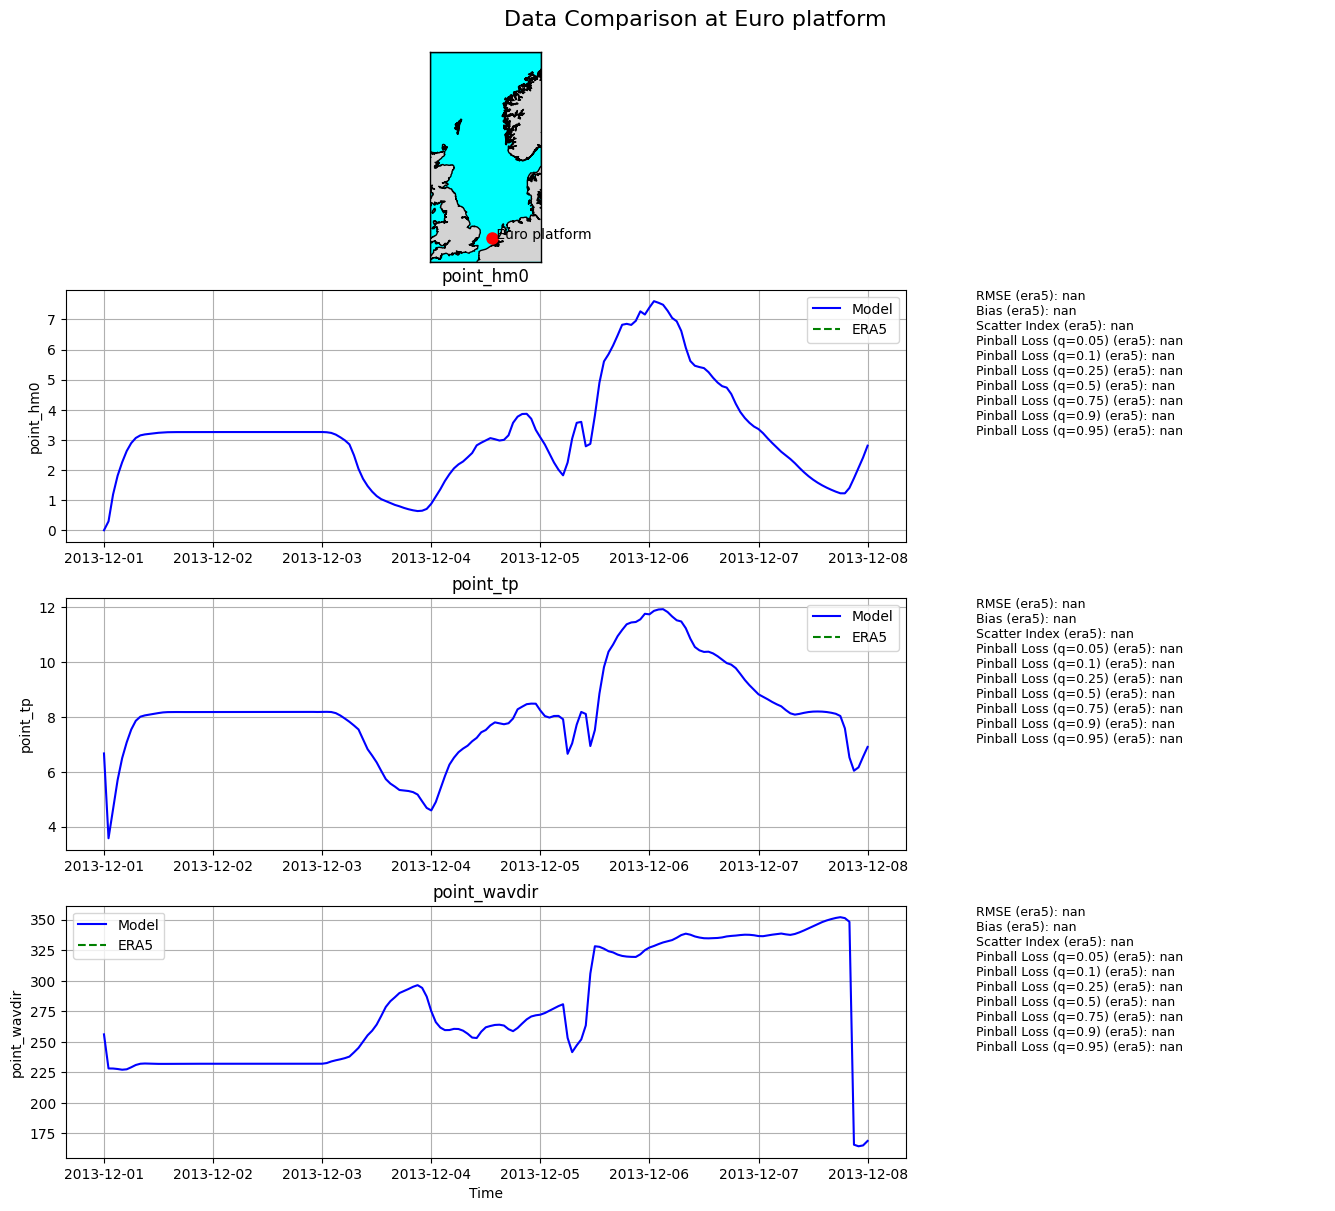

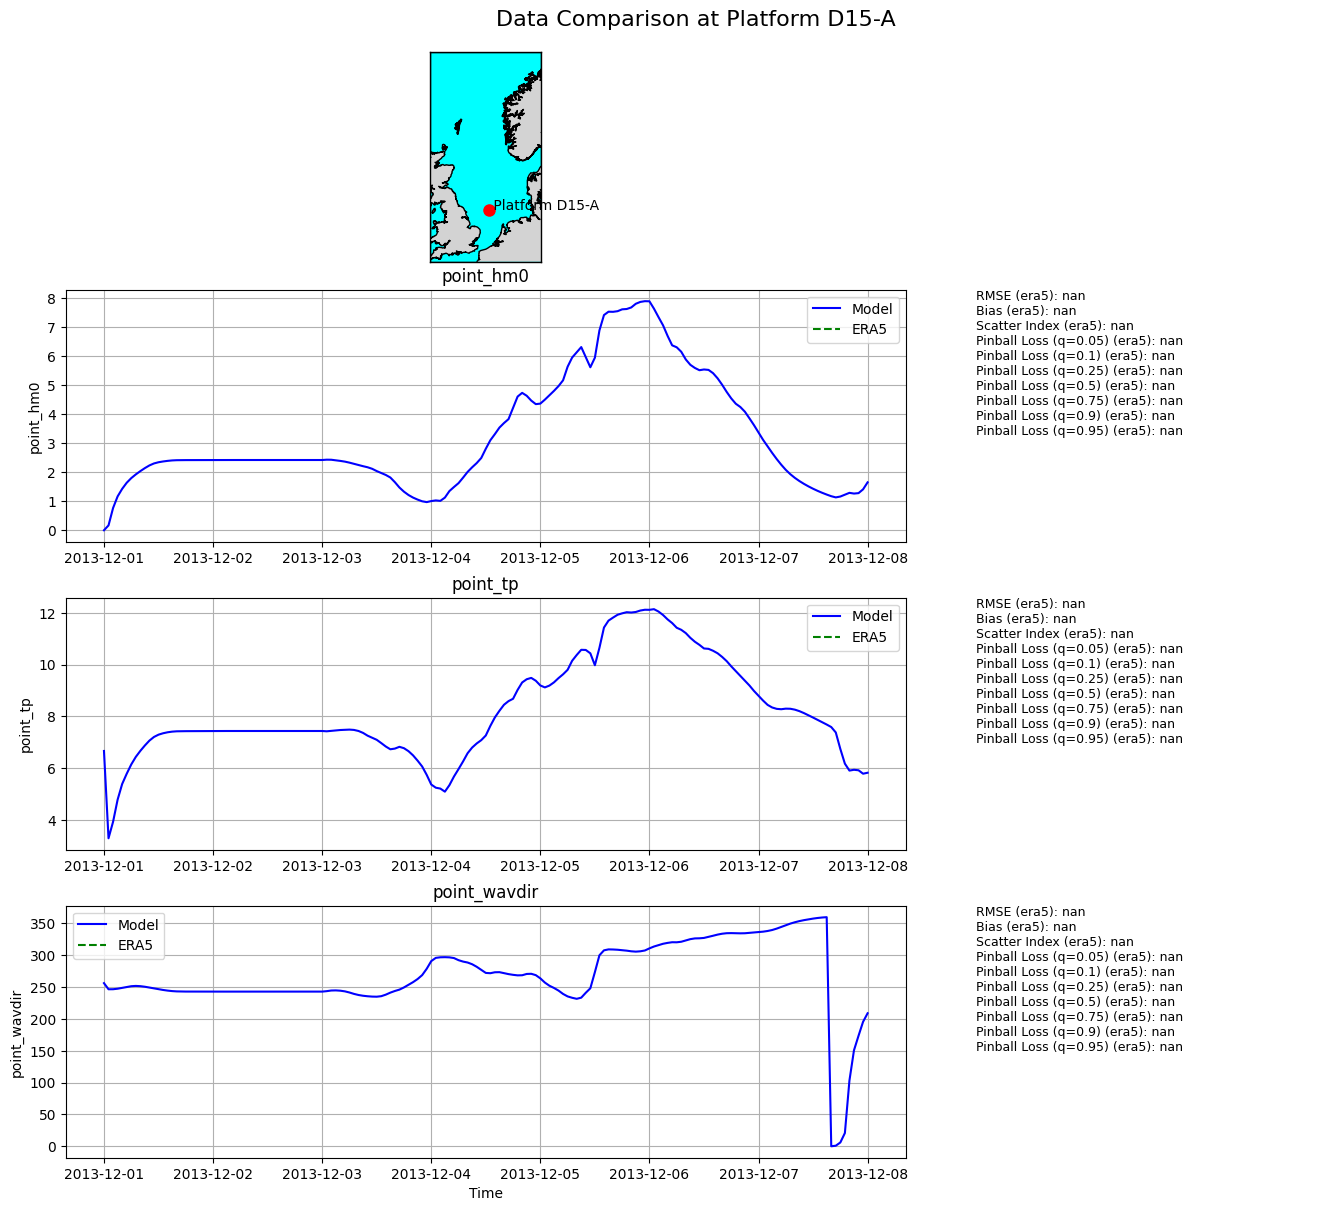

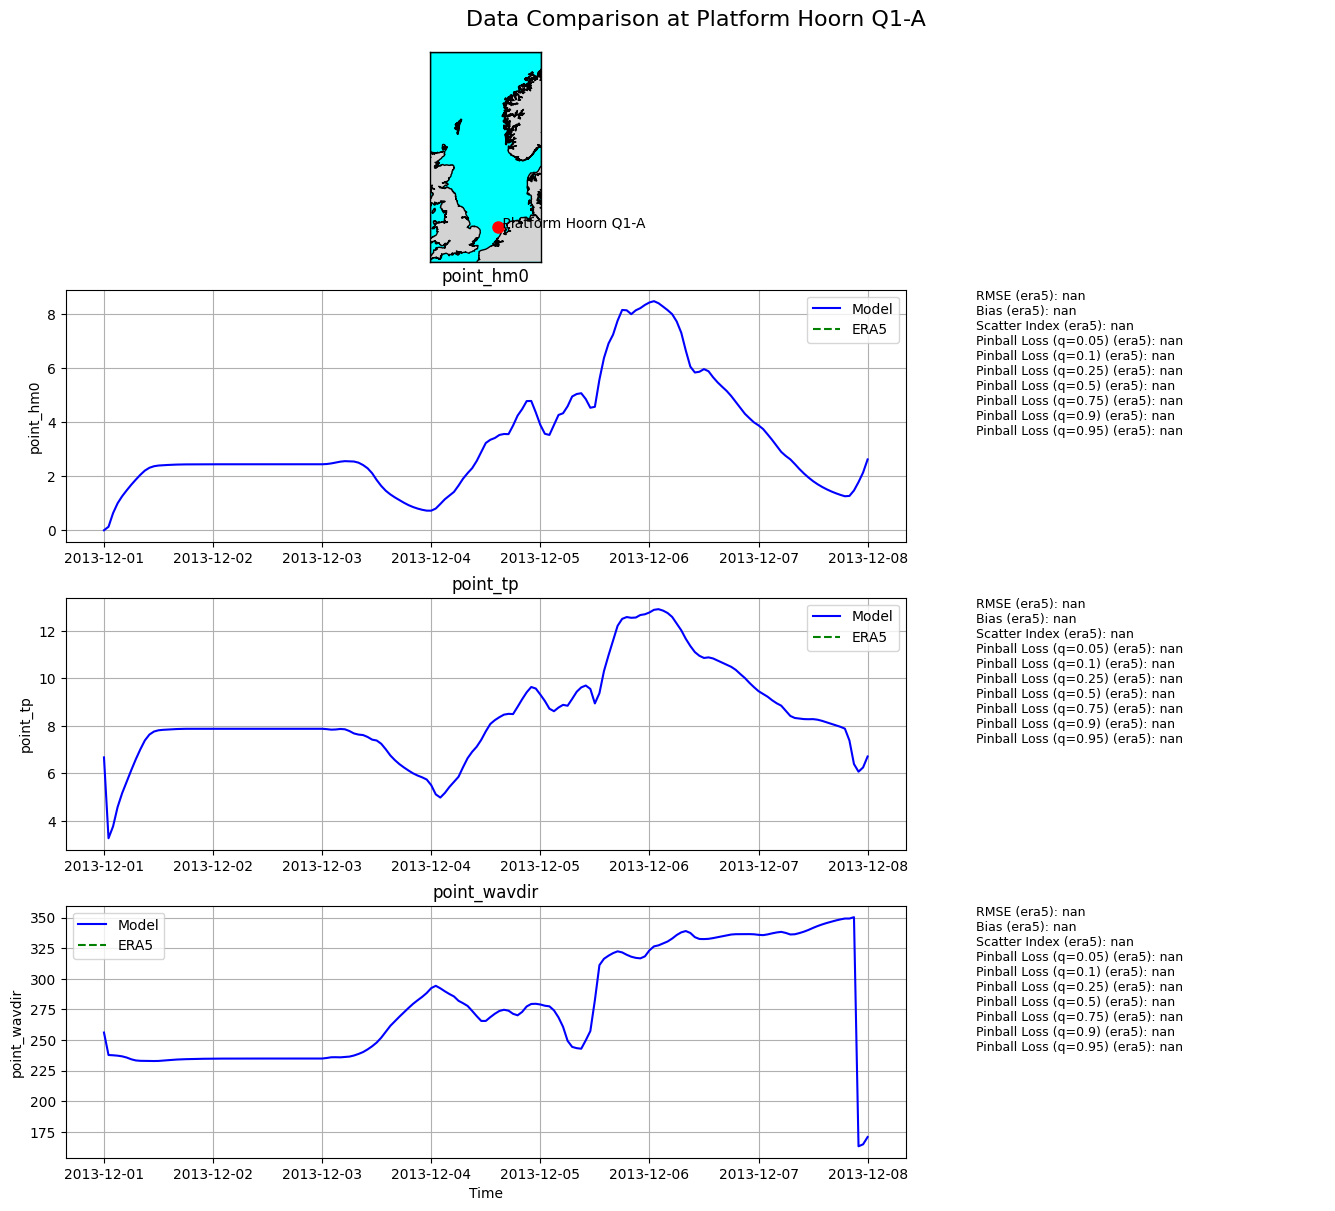

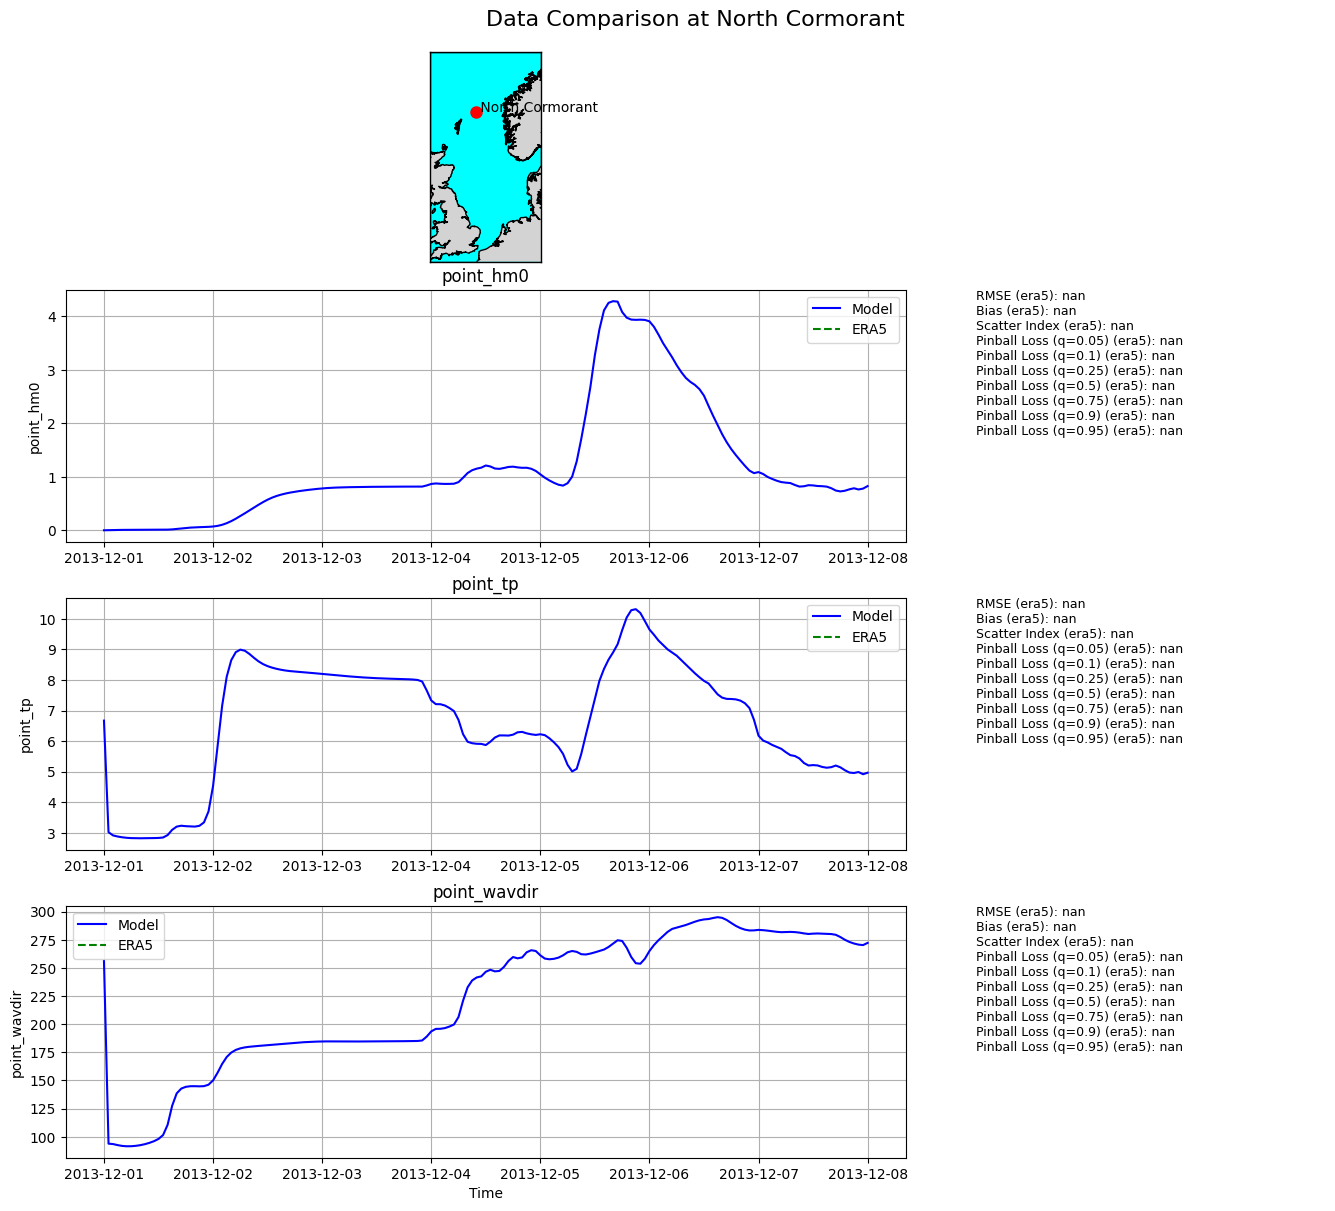

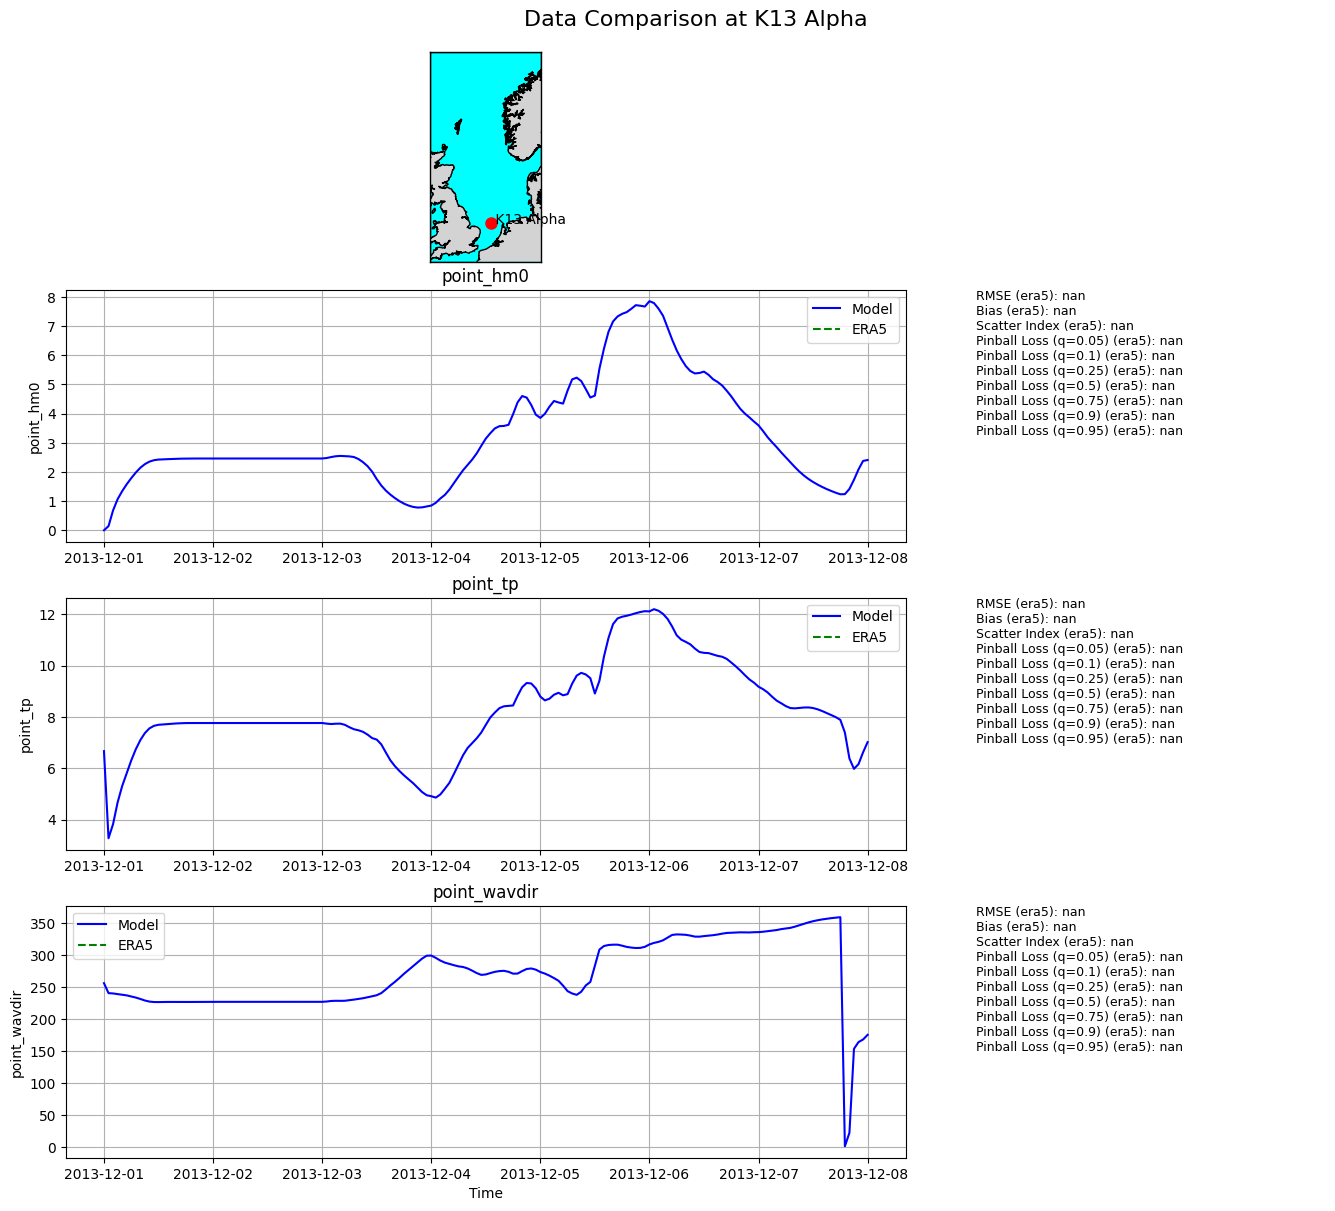

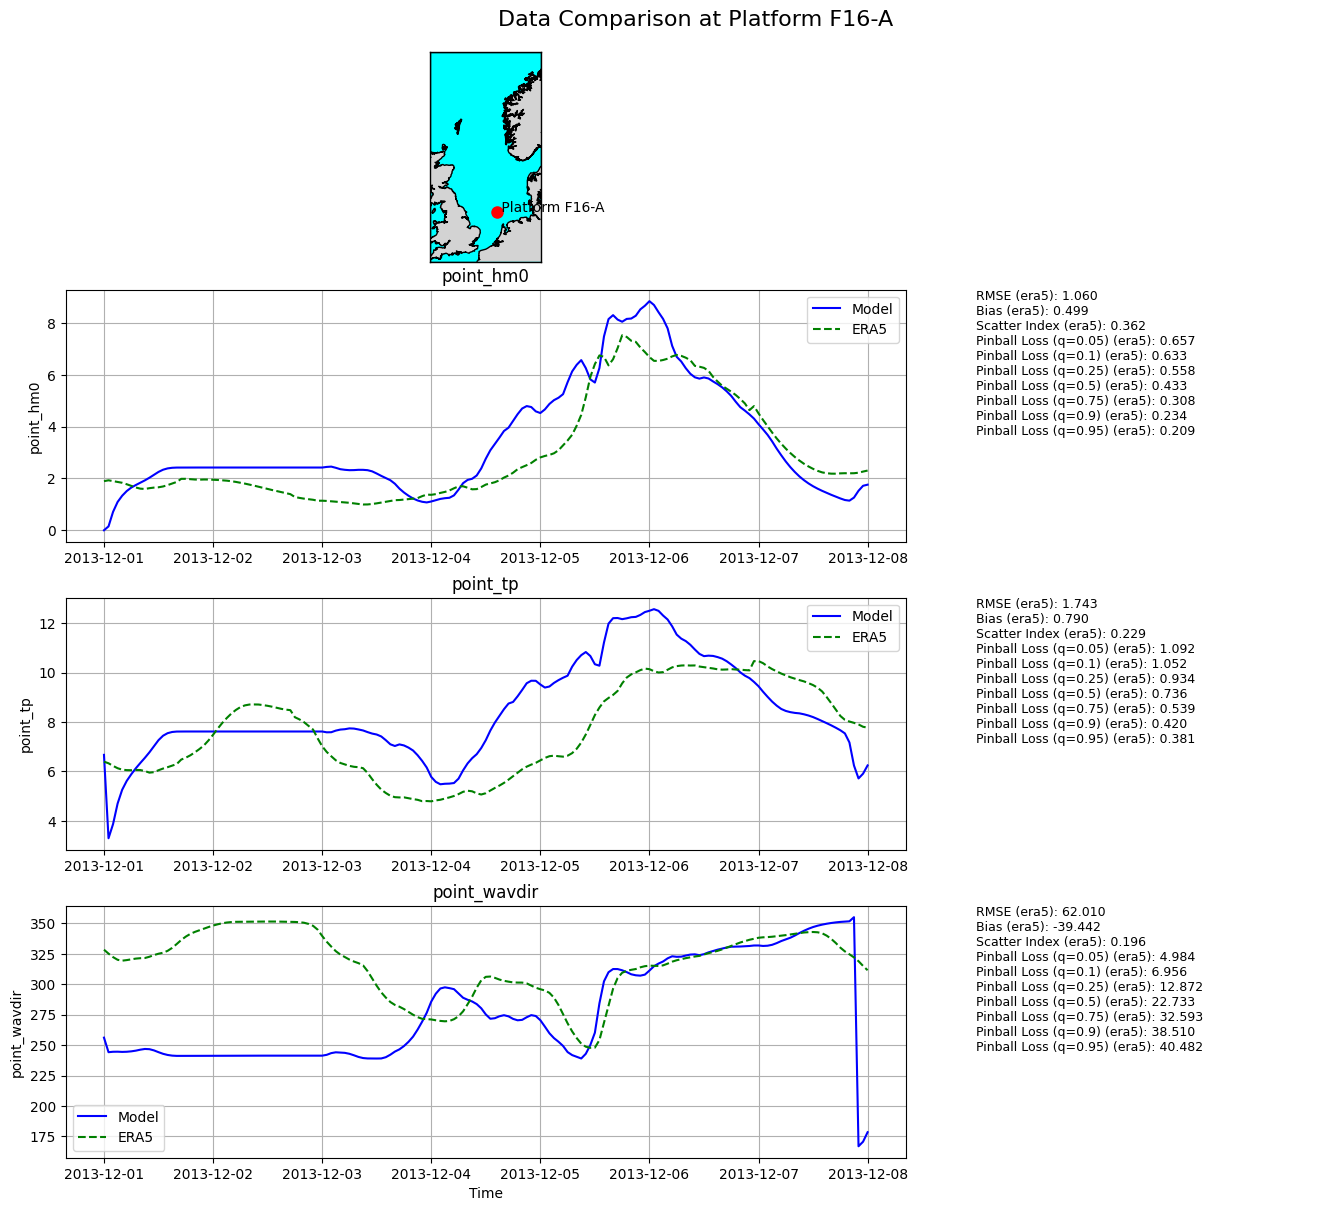

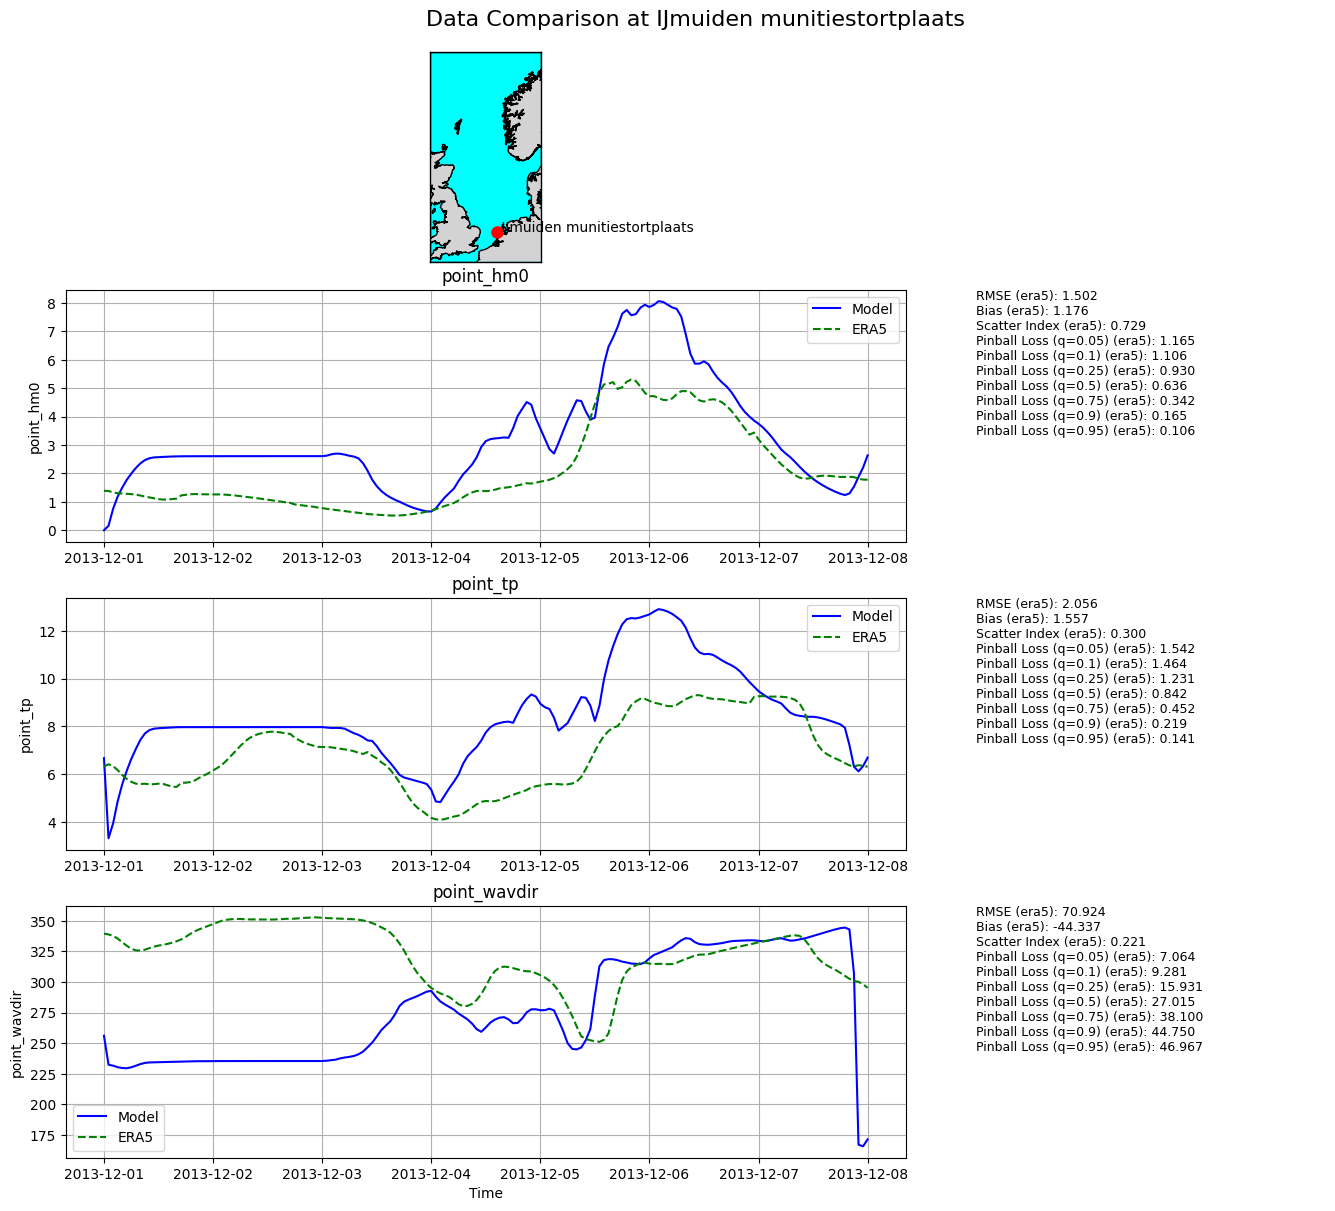

In [29]:
plot_all_stations(
    station_names = station_names,
    model_df=df_model,
    era5_df=df_era5,
    model_vars=variable_list,
    benchmarks=["era5"],
    map_variable_era5 = variable_mapping_era5,
    df_statistics=df_statistics

)

# MAPS

In [20]:
bnd_path = os.path.join(model_path, 'hurrywave.bnd')
bnd = pd.read_csv(bnd_path, header=0, sep=' ', names=['x', 'y'])
bnd = np.array(bnd)

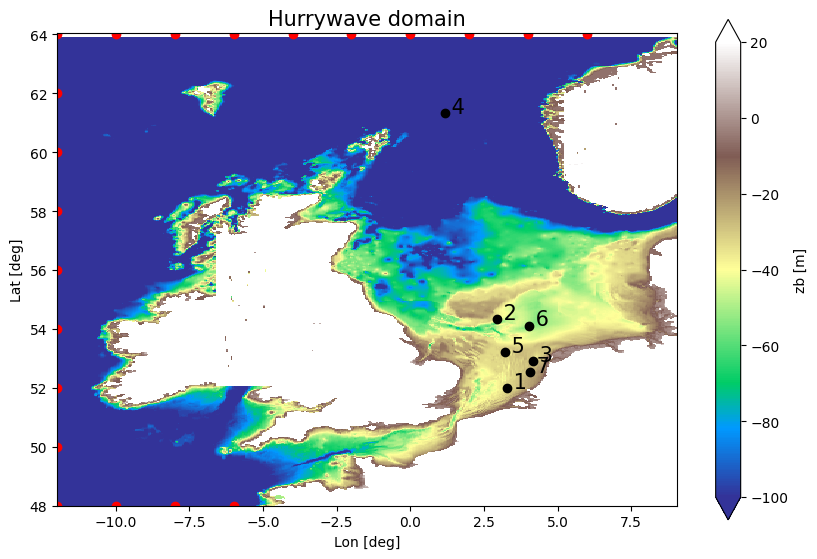

In [21]:
# plot bed level - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['zb'].plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "terrain",
                 vmin = -100, vmax = 20,
                 cbar_kwargs={'label': 'zb [m]'})

plt.scatter(his.station_x, his.station_y, color='k')
for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
    plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')

plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
#xu_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

output_path = os.path.join(output_dir, 'bathy3.png')
fig.savefig(output_path, dpi=300, bbox_inches='tight')

We can plot other variables on this map, such as the maximum significant waveheight (Hm0_max)

Animation of the hurricane track (Check your output folder for the results!)

In [22]:
modig["Hm0"]

<xarray.DataArray 'hm0' (time: 337, n: 481, m: 421)> Size: 273MB
[68242837 values with dtype=float32]
Coordinates:
    x        (n, m) float32 810kB ...
    y        (n, m) float32 810kB ...
  * time     (time) datetime64[ns] 3kB 2013-12-01 ... 2013-12-08
Dimensions without coordinates: n, m
Attributes:
    units:          m
    standard_name:  sea_surface_wave_significant_height
    long_name:      Significant wave height Hm0 (m)

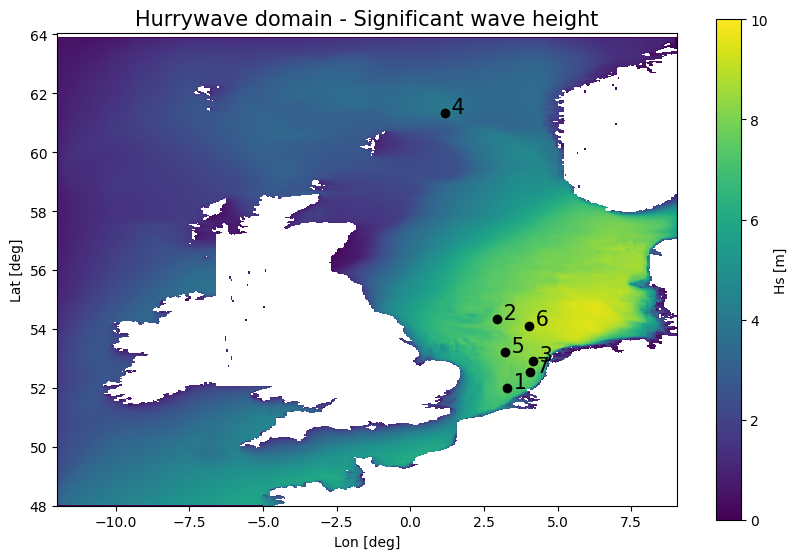

In [23]:
# plot wave height - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['Hm0'].isel(time=-97).plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "viridis",
                 vmin = 0, vmax = 10,
                 cbar_kwargs={'label': 'Hs [m]'})

plt.scatter(his.station_x, his.station_y, color='k')
for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
    plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain - Significant wave height', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]') 

#plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
#xu_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

output_path = os.path.join(output_dir, 'waveheight3.png')
fig.savefig(output_path, dpi=300, bbox_inches='tight')

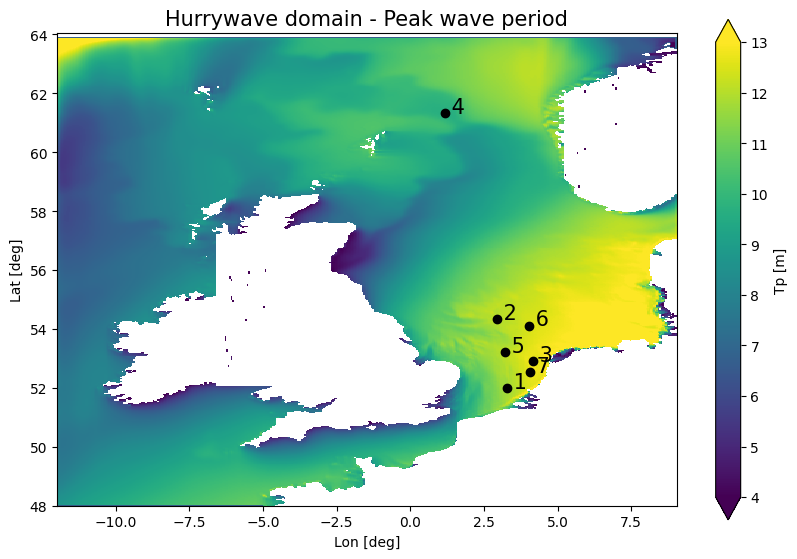

In [24]:
# plot wave period - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['Tp'].isel(time=-97).plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "viridis",
                 vmin = 4, vmax = 13,
                 cbar_kwargs={'label': 'Tp [m]'})

plt.scatter(his.station_x, his.station_y, color='k')
for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
    plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain - Peak wave period', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')

# plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
#xu_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

output_path = os.path.join(output_dir, 'waveperiod3.png')
fig.savefig(output_path, dpi=300, bbox_inches='tight')

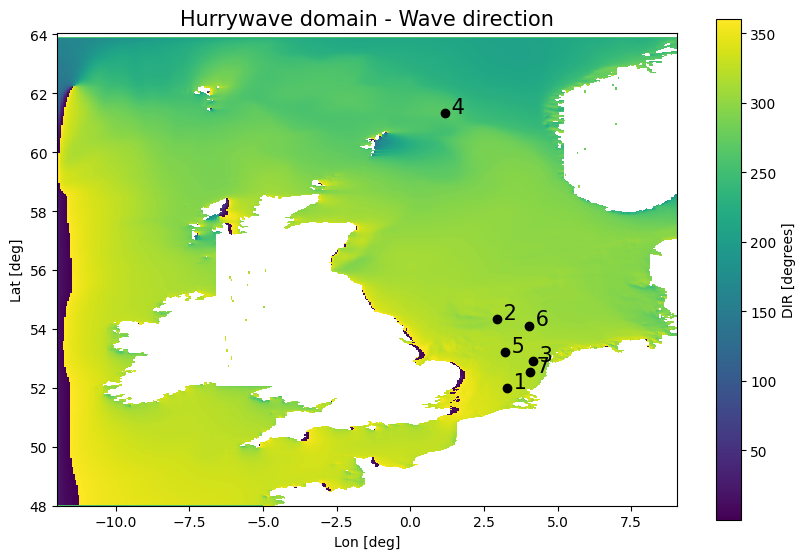

In [25]:
# plot wave direction - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['DIR'].isel(time=-97).plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "viridis",
                 cbar_kwargs={'label': 'DIR [degrees]'})

plt.scatter(his.station_x, his.station_y, color='k')
for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
    plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain - Wave direction', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')

# plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
#xu_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

output_path = os.path.join(output_dir, 'direction3.png')
fig.savefig(output_path, dpi=300, bbox_inches='tight')

In [26]:
modig

{'msk': <xarray.DataArray 'msk' (n: 481, m: 421)> Size: 810kB
 [202501 values with dtype=float32]
 Coordinates:
     x        (n, m) float32 810kB ...
     y        (n, m) float32 810kB ...
 Dimensions without coordinates: n, m
 Attributes:
     units:          -
     standard_name:  land_binary_mask
     long_name:      msk_active_cells
     description:    inactive=0, active=1, boundary=2,
 'zb': <xarray.DataArray 'zb' (n: 481, m: 421)> Size: 810kB
 [202501 values with dtype=float32]
 Coordinates:
     x        (n, m) float32 810kB ...
     y        (n, m) float32 810kB ...
 Dimensions without coordinates: n, m
 Attributes:
     units:          m
     standard_name:  altitude
     long_name:      bed_level_above_reference_level,
 'Hm0': <xarray.DataArray 'hm0' (time: 337, n: 481, m: 421)> Size: 273MB
 [68242837 values with dtype=float32]
 Coordinates:
     x        (n, m) float32 810kB ...
     y        (n, m) float32 810kB ...
   * time     (time) datetime64[ns] 3kB 2013-12-01 ... 2